<a href="https://colab.research.google.com/github/anuj-glitch/Image-Super-Resolution/blob/master/Super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anuj4444","key":"d1f410b884ef51c67881d34546b14f5a"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityachandrasekhar/image-super-resolution

 98% 294M/301M [00:02<00:00, 130MB/s]
100% 301M/301M [00:02<00:00, 124MB/s]


In [3]:
! mkdir data
! unzip image-super-resolution.zip -d data

Archive:  image-super-resolution.zip
  inflating: data/dataset/Raw Data/high_res/0.png  
  inflating: data/dataset/Raw Data/high_res/1.png  
  inflating: data/dataset/Raw Data/high_res/10.png  
  inflating: data/dataset/Raw Data/high_res/100.png  
  inflating: data/dataset/Raw Data/high_res/101.png  
  inflating: data/dataset/Raw Data/high_res/102.png  
  inflating: data/dataset/Raw Data/high_res/103.png  
  inflating: data/dataset/Raw Data/high_res/104.png  
  inflating: data/dataset/Raw Data/high_res/105.png  
  inflating: data/dataset/Raw Data/high_res/106.png  
  inflating: data/dataset/Raw Data/high_res/107.png  
  inflating: data/dataset/Raw Data/high_res/108.png  
  inflating: data/dataset/Raw Data/high_res/109.png  
  inflating: data/dataset/Raw Data/high_res/11.png  
  inflating: data/dataset/Raw Data/high_res/110.png  
  inflating: data/dataset/Raw Data/high_res/111.png  
  inflating: data/dataset/Raw Data/high_res/112.png  
  inflating: data/dataset/Raw Data/high_res/113.png

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

base_dir = "/content/data/dataset/"

def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'low_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = process_image(img)
            low_res_images.append(img)
        
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = process_image(img)
            high_res_images.append(img)
    
    return np.array(low_res_images), np.array(high_res_images)

def process_image(image):
    return image/255


In [5]:
train_x, train_y =  load_data(base_dir+'train/')
val_x, val_y = load_data(base_dir+'val/')
train_x.shape

(685, 256, 256, 3)

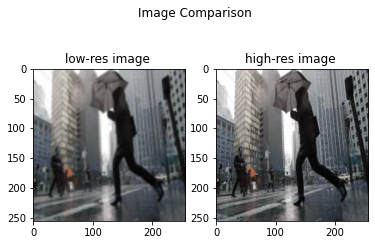

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image Comparison')
ax1.imshow(train_x[44])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[44])
ax2.title.set_text("high-res image ")

In [30]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)

    l3 = MaxPooling2D(padding='same')(l2)
    #l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l7)
    
    l8 = UpSampling2D()(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

model = build_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_11[0][0]                  
_______________________________________________________________________________________

In [31]:
model.fit(train_x, train_y,
          epochs = 25,
          batch_size = 32,
          verbose = 1,
          shuffle = True)

Epoch 1/25
22/22 [==============================] - 13s 578ms/step - loss: 0.1074
Epoch 2/25
22/22 [==============================] - 13s 584ms/step - loss: 0.0082
Epoch 3/25
22/22 [==============================] - 13s 585ms/step - loss: 0.0041
Epoch 4/25
22/22 [==============================] - 13s 583ms/step - loss: 0.0026
Epoch 5/25
22/22 [==============================] - 13s 585ms/step - loss: 0.0022
Epoch 6/25
22/22 [==============================] - 13s 585ms/step - loss: 0.0020
Epoch 7/25
22/22 [==============================] - 13s 587ms/step - loss: 0.0019
Epoch 8/25
22/22 [==============================] - 13s 587ms/step - loss: 0.0018
Epoch 9/25
22/22 [==============================] - 13s 587ms/step - loss: 0.0018
Epoch 10/25
22/22 [==============================] - 13s 584ms/step - loss: 0.0017
Epoch 11/25
22/22 [==============================] - 13s 583ms/step - loss: 0.0017
Epoch 12/25
22/22 [==============================] - 13s 584ms/step - loss: 0.0016
Epoch 13/25
2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


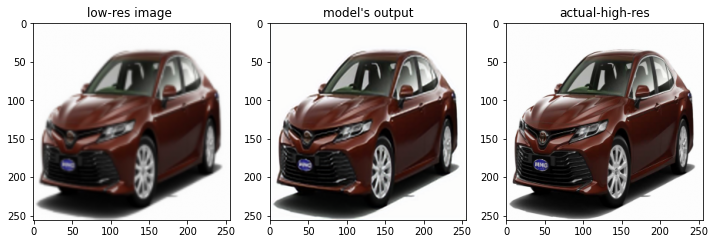

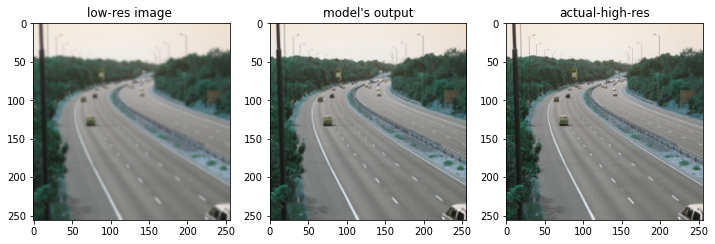

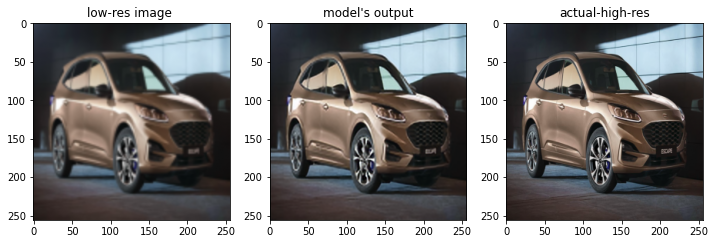

In [68]:
predict_y = model.predict(val_x)
import numpy as np

for j, i in enumerate(val_x[:3]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
    
    ax1.imshow(i)
    ax1.title.set_text("low-res image ")
    ax2.imshow(predict_y[j])
    ax2.title.set_text("model's output")
    ax3.imshow(val_y[j])
    ax3.title.set_text("actual-high-res")